In [1]:
from datetime import datetime

# if False, model is set to `PRETRAINED_PATH` model
is_train = True

# if True, evaluate on validation dataset
is_evaluate = False

# if True, run inference on test dataset
is_inference = True

# if True and `is_train` == True, `PRETRAINED_PATH` model is trained further
is_resume_training = False

# Perform augmentation
is_augment = False

SEED = int(datetime.now().timestamp())

In [2]:
from pathlib import Path

TRAIN_IMG_DIR = Path("/kaggle/input/dlsprint2/badlad/images/train")

TRAIN_COCO_PATH = Path("/kaggle/input/dlsprint2/badlad/labels/coco_format/train/badlad-train-coco.json")

TEST_IMG_DIR = Path("/kaggle/input/dlsprint2/badlad/images/test")

TEST_METADATA_PATH = Path("/kaggle/input/dlsprint2/badlad/badlad-test-metadata.json")

# Training output directory
# OUTPUT_DIR = Path("./output")
# OUTPUT_MODEL = OUTPUT_DIR/"model_final.pth"

# # Path to your pretrained model weights
# PRETRAINED_PATH = Path("")

In [1]:
%%capture
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [2]:
from datetime import datetime

# if False, model is set to `PRETRAINED_PATH` model
is_train = True

# if True, evaluate on validation dataset
is_evaluate = False

# if True, run inference on test dataset
is_inference = True

# if True and `is_train` == True, `PRETRAINED_PATH` model is trained further
is_resume_training = True

# Perform augmentation
is_augment = False

SEED = int(datetime.now().timestamp())

In [7]:
from pathlib import Path

TRAIN_IMG_DIR = Path("badlad/images/train")

TRAIN_COCO_PATH = Path("badlad/labels/coco_format/train/badlad-train-coco.json")

TEST_IMG_DIR = Path("badlad/images/test")

TEST_METADATA_PATH = Path("badlad/badlad-test-metadata.json")

# Training output directory
# OUTPUT_DIR = Path("./output")
# OUTPUT_MODEL = OUTPUT_DIR/"model_final.pth"

# # Path to your pretrained model weights
# PRETRAINED_PATH = Path("/kaggle/working/archive/data.pkl")

In [8]:
# detectron2
from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.utils.logger import setup_logger
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm  # progress bar
import matplotlib.pyplot as plt
import json
import cv2
import copy
from typing import Optional

from IPython.display import FileLink

# torch
import torch

import gc

import warnings
# Ignore "future" warnings and Data-Frame-Slicing warnings.
warnings.filterwarnings('ignore')

setup_logger()

<Logger detectron2 (DEBUG)>

In [9]:
with TRAIN_COCO_PATH.open() as f:
    train_dict = json.load(f)

with TEST_METADATA_PATH.open() as f:
    test_dict = json.load(f)

print("#### LABELS AND METADATA LOADED ####")

#### LABELS AND METADATA LOADED ####


In [10]:
def organize_coco_data(data_dict: dict) -> tuple[list[str], list[dict], list[dict]]:
    thing_classes: list[str] = []

    # Map Category Names to IDs
    for cat in data_dict['categories']:
        thing_classes.append(cat['name'])

    # Images
    images_metadata: list[dict] = data_dict['images']

    # Convert COCO annotations to detectron2 annotations format
    data_annotations = []
    for ann in data_dict['annotations']:
        # coco format -> detectron2 format
        annot_obj = {
            # Annotation ID
            "id": ann['id'],

            # Segmentation Polygon (x, y) coords
            "gt_masks": ann['segmentation'],

            # Image ID for this annotation (Which image does this annotation belong to?)
            "image_id": ann['image_id'],

            # Category Label (0: paragraph, 1: text box, 2: image, 3: table)
            "category_id": ann['category_id'],

            "x_min": ann['bbox'][0],  # left
            "y_min": ann['bbox'][1],  # top
            "x_max": ann['bbox'][0] + ann['bbox'][2],  # left+width
            "y_max": ann['bbox'][1] + ann['bbox'][3]  # top+height
        }
        data_annotations.append(annot_obj)

    return thing_classes, images_metadata, data_annotations

In [11]:
thing_classes, images_metadata, data_annotations = organize_coco_data(
    train_dict
)

thing_classes_test, images_metadata_test, _ = organize_coco_data(
    test_dict
)

In [12]:
print(thing_classes)


['paragraph', 'text_box', 'image', 'table']


In [17]:
train_metadata = pd.DataFrame(images_metadata)
train_metadata = train_metadata[['id', 'file_name', 'width', 'height']]
train_metadata = train_metadata.rename(columns={"id": "image_id"})
print("train_metadata size=", len(train_metadata))
train_metadata.head(5)

train_metadata size= 20365


image_id                                 file_name  width  height
0         0  846df66a-610e-4356-b369-6788885a0dc5.png    720     995
1         1  ac85875b-7d47-4072-8663-d65f7c5c58bd.png   1700    2800
2         2  12f55392-4b58-4e62-b879-057554734a29.png   1700    2800
3         3  da7472db-1f45-4ff0-834c-b018dbbed3c2.png   1700    2800
4         4  ff06ef6e-d551-4be7-b06c-16bc9b865b82.png    480     800

In [13]:
train_annot_df = pd.DataFrame(data_annotations)
print("train_annot_df size=", len(train_annot_df))
train_annot_df.head(5)

train_annot_df size= 425101


id                                           gt_masks  image_id   
0   0  [[86.328, 179.007, 657.662, 183.008, 654.662, ...         0  \
1   1  [[102.995, 281.675, 657.328, 281.675, 652.995,...         0   
2   2  [[509.995, 539.345, 602.328, 543.012, 599.662,...         0   
3   3  [[273.995, 18.006, 443.995, 20.006, 433.662, 1...         0   
4   4  [[540.995, 88.673, 647.328, 89.006, 647.995, 1...         0   

   category_id  x_min  y_min  x_max  y_max  
0            0   56.0  179.0  657.0  277.0  
1            0   54.0  281.0  657.0  378.0  
2            2  509.0  539.0  666.0  585.0  
3            1  273.0   18.0  443.0  101.0  
4            1  540.0   88.0  647.0  129.0

In [14]:
test_metadata = pd.DataFrame(images_metadata_test)
test_metadata = test_metadata[['id', 'file_name', 'width', 'height']]
test_metadata = test_metadata.rename(columns={"id": "image_id"})
print("test_metadata size=", len(test_metadata))
test_metadata.head(5)

test_metadata size= 13000


image_id                                 file_name  width  height
0         0  96eee398-1275-4768-be89-ec945e6c8bb0.png    720    1018
1         1  9b77c241-8292-4133-ab7a-0398a99f30a8.png    720    1019
2         2  3a6ac54b-d3f6-4783-9f71-b6ae29c93f7d.png    720    1105
3         3  2d0e29cd-83cb-4426-9663-1368c1975c37.png   1080    1920
4         4  f8c22a4a-6c89-4179-8845-12405bfd0035.png   1080    1920

In [15]:
TRAIN_SPLIT = 0.95


In [18]:
n_dataset = len(train_metadata)
n_train = int(n_dataset * TRAIN_SPLIT)
print("n_dataset", n_dataset, "n_train", n_train, "n_val", n_dataset-n_train)

np.random.seed(SEED)

inds = np.random.permutation(n_dataset)
train_inds, valid_inds = inds[:n_train], inds[n_train:]

n_dataset 20365 n_train 19346 n_val 1019


In [19]:
def convert_coco_to_detectron2_format(
    imgdir: Path,
    metadata_df: pd.DataFrame,
    annot_df: Optional[pd.DataFrame] = None,
    target_indices: Optional[np.ndarray] = None,
):

    dataset_dicts = []
    for _, train_meta_row in tqdm(metadata_df.iterrows(), total=len(metadata_df)):
        # Iterate over each image
        image_id, filename, width, height = train_meta_row.values

        annotations = []

        # If train/validation data, then there will be annotations
        if annot_df is not None:
            for _, ann in annot_df.query("image_id == @image_id").iterrows():
                # Get annotations of current iteration's image
                class_id = ann["category_id"]
                gt_masks = ann["gt_masks"]
                bbox_resized = [
                    float(ann["x_min"]),
                    float(ann["y_min"]),
                    float(ann["x_max"]),
                    float(ann["y_max"]),
                ]

                annotation = {
                    "bbox": bbox_resized,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "segmentation": gt_masks,
                    "category_id": class_id,
                }

                annotations.append(annotation)

        # coco format -> detectron2 format dict
        record = {
            "file_name": str(imgdir/filename),
            "image_id": image_id,
            "width": width,
            "height": height,
            "annotations": annotations
        }

        dataset_dicts.append(record)

    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

In [47]:
DatasetCatalog.clear()


In [21]:
DATA_REGISTER_TRAINING = "my_dataset_train"
DATA_REGISTER_VALID    = "my_dataset_val"
DATA_REGISTER_TEST     = "badlad_test"

In [23]:
# Register Validation data
DatasetCatalog.register(
    DATA_REGISTER_VALID,
    lambda: convert_coco_to_detectron2_format(
        TRAIN_IMG_DIR,
        train_metadata,
        train_annot_df,
        target_indices=valid_inds,
    ),
)

# Set Validation data categories
MetadataCatalog.get(DATA_REGISTER_VALID).set(thing_classes=thing_classes)

dataset_dicts_valid = DatasetCatalog.get(DATA_REGISTER_VALID)
metadata_dicts_valid = MetadataCatalog.get(DATA_REGISTER_VALID)

print("dicts valid size=", len(dataset_dicts_valid))
print("##############")

  0%|          | 0/20365 [00:00<?, ?it/s]

dicts valid size= 1019
##############


In [24]:
# Register Test Inference data
DatasetCatalog.register(
    DATA_REGISTER_TEST,
    lambda: convert_coco_to_detectron2_format(
        TEST_IMG_DIR,
        test_metadata,
    )
)

# Set Test data categories
MetadataCatalog.get(DATA_REGISTER_TEST).set(
    thing_classes=thing_classes_test
)

dataset_dicts_test = DatasetCatalog.get(DATA_REGISTER_TEST)
metadata_dicts_test = MetadataCatalog.get(DATA_REGISTER_TEST)

# print("dicts valid size=", len(dataset_dicts_test))
# print("################")

  0%|          | 0/13000 [00:00<?, ?it/s]

                                     0            1            2            3   
data_time                     1.315991     2.132973     1.531470     1.094928  \
eta_seconds                8517.159030  8918.929632  9214.055017  8735.585977   
fast_rcnn/cls_accuracy        0.842773     0.862305     0.876953     0.874512   
fast_rcnn/false_negative      0.471505     0.384000     0.351783     0.324219   
fast_rcnn/fg_cls_accuracy     0.462348     0.588118     0.623047     0.638672   
iteration                    19.000000    39.000000    59.000000    79.000000   
loss_box_reg                  0.513742     0.501059     0.454807     0.480334   
loss_cls                      0.433947     0.364018     0.345540     0.343407   
loss_mask                     0.377942     0.352605     0.321184     0.314953   
loss_rpn_cls                  0.221860     0.169542     0.159270     0.130592   
loss_rpn_loc                  0.336040     0.321291     0.287360     0.283349   
lr                          

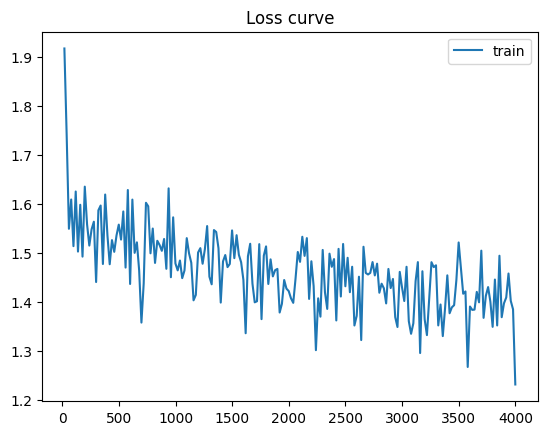

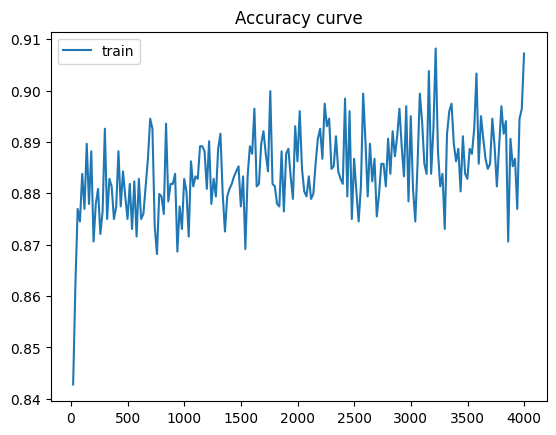

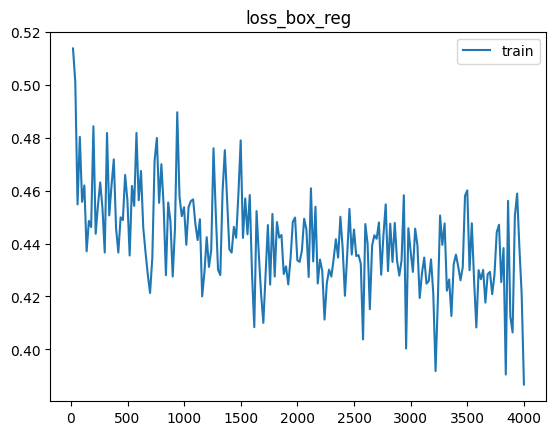

In [27]:
if is_train:
    # Load metrics
    metrics_df = pd.read_json("output_aug1/metrics.json", orient="records", lines=True
    )
    mdf = metrics_df.sort_values("iteration")
    print(mdf.head(10).T)

    # Plot loss
    fig, ax = plt.subplots()

    mdf1 = mdf[~mdf["total_loss"].isna()]
    ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")

    if "validation_loss" in mdf.columns:
        mdf2 = mdf[~mdf["validation_loss"].isna()]
        ax.plot(mdf2["iteration"], mdf2["validation_loss"],
                c="C1", label="validation")

    ax.legend()
    ax.set_title("Loss curve")
    plt.show()

    # Plot Accuracy
    fig, ax = plt.subplots()

    mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
    ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"],
            c="C0", label="train")

    ax.legend()
    ax.set_title("Accuracy curve")
    plt.show()

    # Plot Bounding Box regressor loss
    fig, ax = plt.subplots()

    mdf1 = mdf[~mdf["loss_box_reg"].isna()]
    ax.plot(mdf1["iteration"], mdf1["loss_box_reg"], c="C0", label="train")

    ax.legend()
    ax.set_title("loss_box_reg")
    plt.show()

In [29]:
MODEL_PATH=Path("output_aug1/model_final.pth")

In [30]:
inf_cfg = get_cfg()

config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"

inf_cfg.merge_from_file(model_zoo.get_config_file(config_name))
inf_cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
inf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
inf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
inf_cfg.MODEL.DEVICE = "cuda"

inf_cfg.DATALOADER.NUM_WORKERS = 2  # lower this if CUDA overflow occurs
inf_cfg.MODEL.WEIGHTS = str(MODEL_PATH)

In [31]:
BATCH = 8  # lower this if CUDA overflow occurs
test_loader = build_detection_test_loader(inf_cfg, DATA_REGISTER_TEST, batch_size=BATCH)

  0%|          | 0/13000 [00:00<?, ?it/s]

[07/07 14:23:10 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| paragraph  | 0            |  text_box  | 0            |   image    | 0            |
|   table    | 0            |            |              |            |              |
|   total    | 0            |            |              |            |              |
[07/07 14:23:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/07 14:23:10 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/07 14:23:10 d2.data.common]: Serializing 13000 elements to byte tensors and concatenating them all ...
[07/07 14:23:10 d2.data.common]: Serialized dataset takes 1.77 MiB


In [32]:
ACCEPTANCE_THRESHOLD = 0.6  # for all categories


In [33]:
print(f"#### MODEL: {inf_cfg.MODEL.WEIGHTS} FOR INFERENCE ####")


#### MODEL: output_aug1/model_final.pth FOR INFERENCE ####


In [34]:
predictor = DefaultPredictor(inf_cfg)


[07/07 14:23:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output_aug1/model_final.pth ...


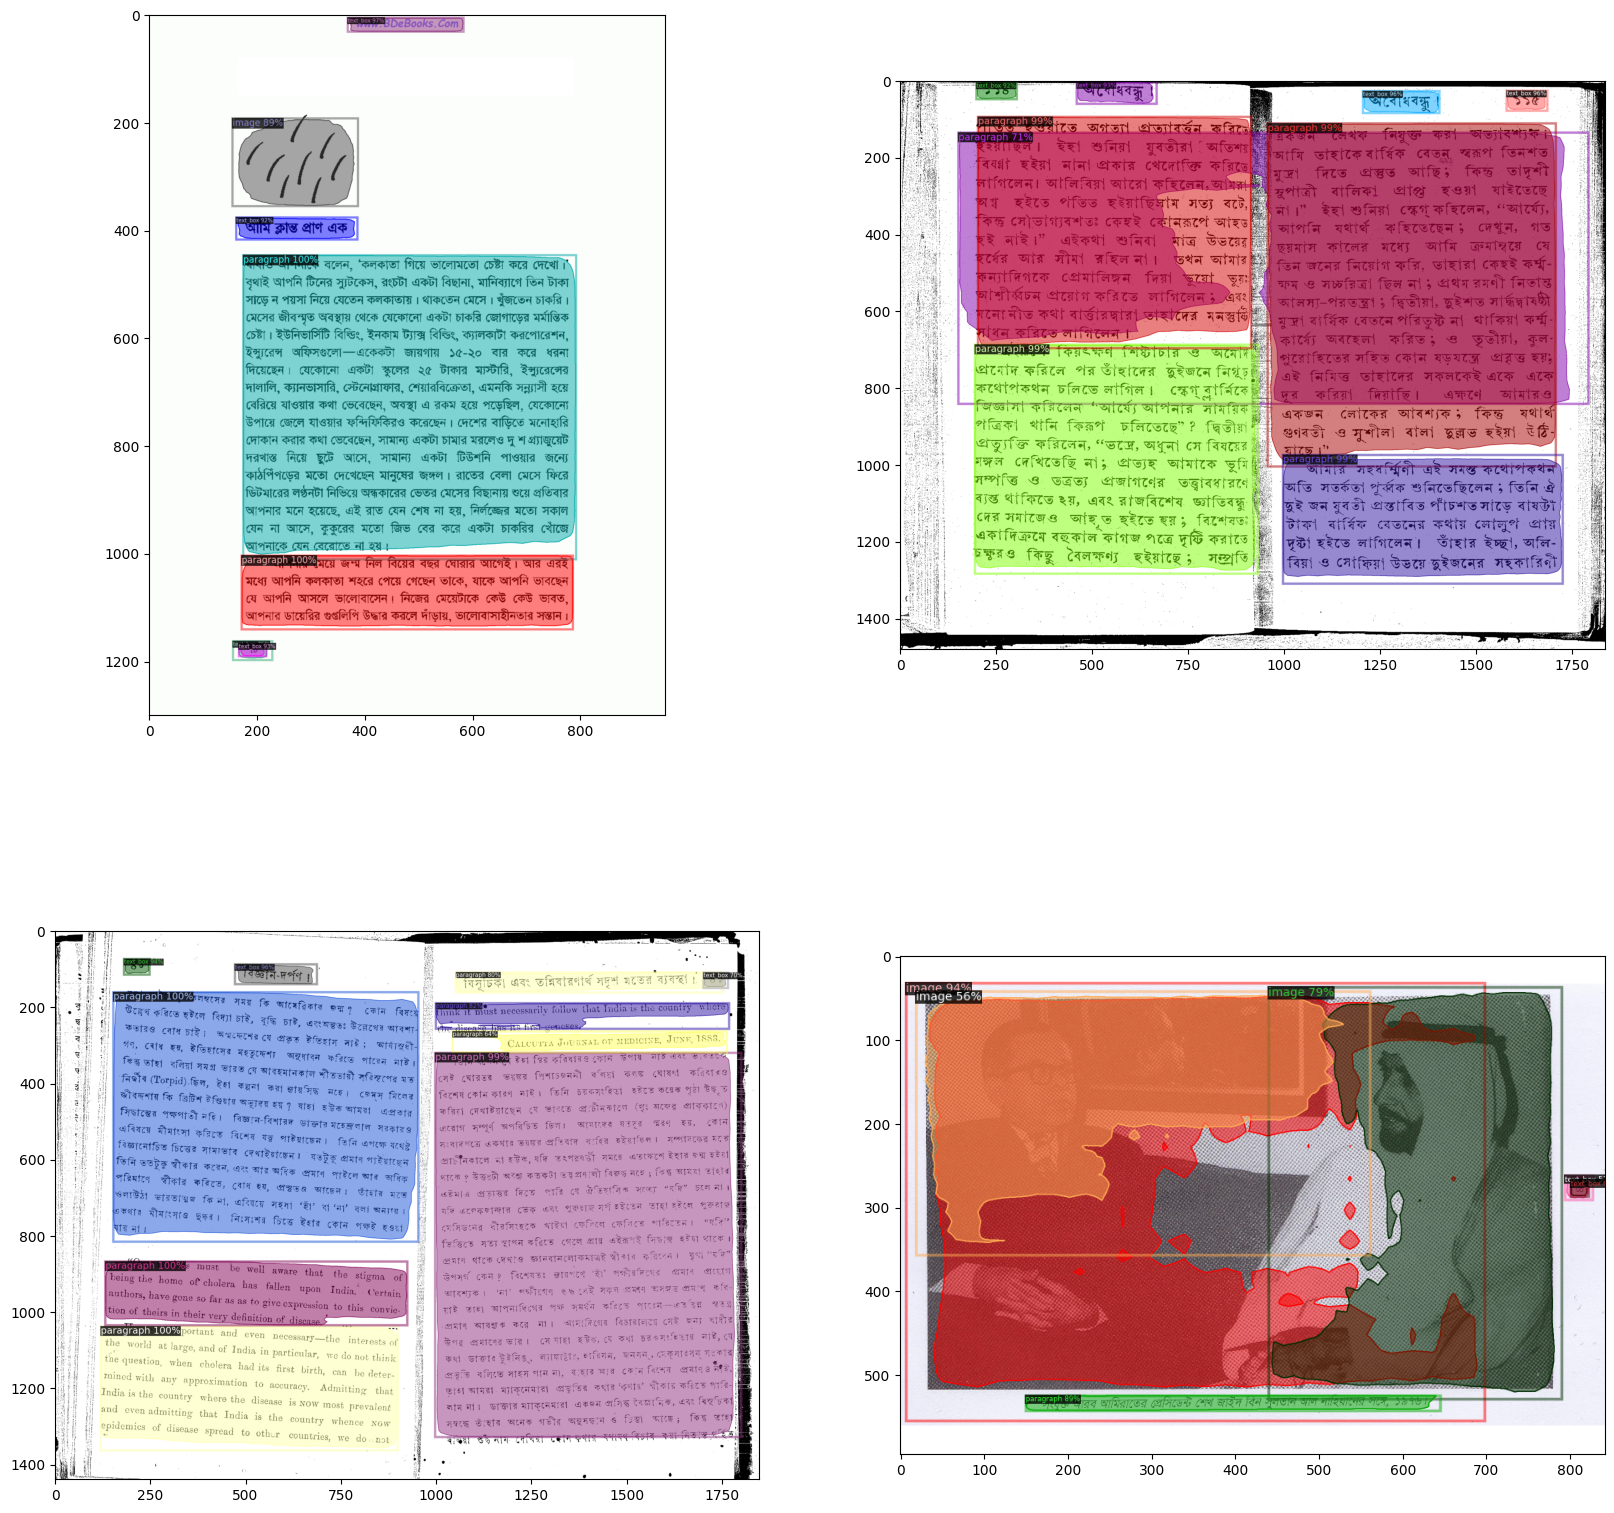

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
indices = [ax[0][0], ax[1][0], ax[0][1], ax[1][1]]

# Show some qualitative results by predicting on test set images
NUM_TEST_SAMPLES = 4
samples = np.random.choice(dataset_dicts_test, NUM_TEST_SAMPLES)

for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img, metadata=metadata_dicts_test, scale=0.5,)
    visualizer = visualizer.draw_instance_predictions(
        outputs["instances"].to("cpu")
    )
    display_img = visualizer.get_image()[:, :, ::-1]
    indices[i].grid(False)
    indices[i].imshow(display_img)

In [36]:
def rebuild_model():
    model = build_model(inf_cfg)
    _ = DetectionCheckpointer(model).load(inf_cfg.MODEL.WEIGHTS)
    return model

In [37]:
model = rebuild_model()

[07/07 14:24:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output_aug1/model_final.pth ...


In [38]:
!export LRU_CACHE_CAPACITY=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [39]:
vars_to_del = ["trainer", "predictor", "outputs"]

for v in vars_to_del:
    if v in globals():
        print(f"Deleting {v}")
        del globals()[v]
    elif v in locals():
        print(f"Deleting {v}")
        del locals()[v]

Deleting predictor
Deleting outputs


In [40]:
def rle_encode(mask):
    pixels = mask.T.flatten()
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return ' '.join(str(x) for x in rle)

In [41]:
@retry_if_cuda_oom
def get_masks(prediction):
    # get masks for each category
    take = prediction.scores >= ACCEPTANCE_THRESHOLD
    pred_masks = (prediction.pred_masks[take] != 0)
    pred_classes = prediction.pred_classes[take]
  
    rles = []
    for cat in range(len(thing_classes)):
        pred_mask = pred_masks[pred_classes == cat]
        
        # pred_mask = retry_if_cuda_oom(torch.any)(pred_mask, dim=0)
        pred_mask = torch.any(pred_mask, dim=0)
        rles.append(rle_encode(pred_mask.short().to("cpu").numpy()))

    return rles

In [42]:
def run_inference(data):
    results = []
    with torch.no_grad():
        outputs = model(data)
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        for idx, output in enumerate(outputs):
            output = output["instances"]

            rles = get_masks(output)

            result = [
                f"{data[idx]['image_id']}_{cat},{rles[cat]}\n"
                for cat in range(len(thing_classes))
            ]

            results.extend(result)

        del outputs, output

    return results

In [44]:
torch.cuda.empty_cache()
gc.collect()

0

In [45]:
if is_inference:
    model.eval()
    submission_file = open("submission.csv", "w")
    submission_file.write("Id,Predicted\n")

    results: list[str] = []
    
    for i, data in enumerate(tqdm(test_loader)):
        res = run_inference(data)
        results.extend(res)
        
        if i % (500 // BATCH) == 0:
            print(f"Inference on batch {i}/{len(test_loader)} done")
            submission_file.writelines(results)
            results = []

    submission_file.writelines(results)
    submission_file.close()

  0%|          | 0/1625 [00:00<?, ?it/s]

Inference on batch 0/1625 done
Inference on batch 62/1625 done
Inference on batch 124/1625 done
Inference on batch 186/1625 done
Inference on batch 248/1625 done
Inference on batch 310/1625 done
Inference on batch 372/1625 done
Inference on batch 434/1625 done
Inference on batch 496/1625 done
Inference on batch 558/1625 done
Inference on batch 620/1625 done
Inference on batch 682/1625 done
Inference on batch 744/1625 done
Inference on batch 806/1625 done
Inference on batch 868/1625 done
Inference on batch 930/1625 done
Inference on batch 992/1625 done
Inference on batch 1054/1625 done
Inference on batch 1116/1625 done
Inference on batch 1178/1625 done
Inference on batch 1240/1625 done
Inference on batch 1302/1625 done
Inference on batch 1364/1625 done
Inference on batch 1426/1625 done
Inference on batch 1488/1625 done
Inference on batch 1550/1625 done
Inference on batch 1612/1625 done


In [ ]:
##COPY PASTE AUGMENTATION


In [48]:
for d in ['train','val']:
    DatasetCatalog.register("my_dataset_"+d, lambda d=d: load_coco_json("badlad/labels/coco_format/train/badlad-train-coco.json".format(d,d),
    image_root= "badlad/images/train".format(d),\
    dataset_name="my_dataset_"+d))

In [49]:
from detectron2.data.datasets import register_coco_instances,load_coco_json

dataset_dicts_train = DatasetCatalog.get("my_dataset_train")

[07/07 14:59:20 d2.data.datasets.coco]: Loading badlad/labels/coco_format/train/badlad-train-coco.json takes 5.19 seconds.
WARNING [07/07 14:59:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/07 14:59:20 d2.data.datasets.coco]: Loaded 20365 images in COCO format from badlad/labels/coco_format/train/badlad-train-coco.json


In [50]:
train_metadata_new = MetadataCatalog.get("my_dataset_train")


{'file_name': 'badlad/images/train/846df66a-610e-4356-b369-6788885a0dc5.png', 'height': 995, 'width': 720, 'image_id': 0, 'annotations': [{'iscrowd': 0, 'bbox': [56.0, 179.0, 601.0, 98.0], 'category_id': 0, 'segmentation': [[86.328, 179.007, 657.662, 183.008, 654.662, 277.342, 560.662, 277.342, 58.995, 272.675, 56.662, 208.008]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [54.0, 281.0, 603.0, 97.0], 'category_id': 0, 'segmentation': [[102.995, 281.675, 657.328, 281.675, 652.995, 368.343, 327.995, 378.01, 60.662, 376.01, 54.995, 312.342, 96.662, 310.009]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [509.0, 539.0, 157.0, 46.0], 'category_id': 2, 'segmentation': [[509.995, 539.345, 602.328, 543.012, 599.662, 566.679, 666.328, 563.346, 658.995, 583.679, 563.328, 585.012, 509.328, 576.679]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [273.0, 18.0, 170.0, 83.0], 'category_id': 1, 'segmentation': [[273.995, 18.006, 443.995, 20.006, 433.662, 1

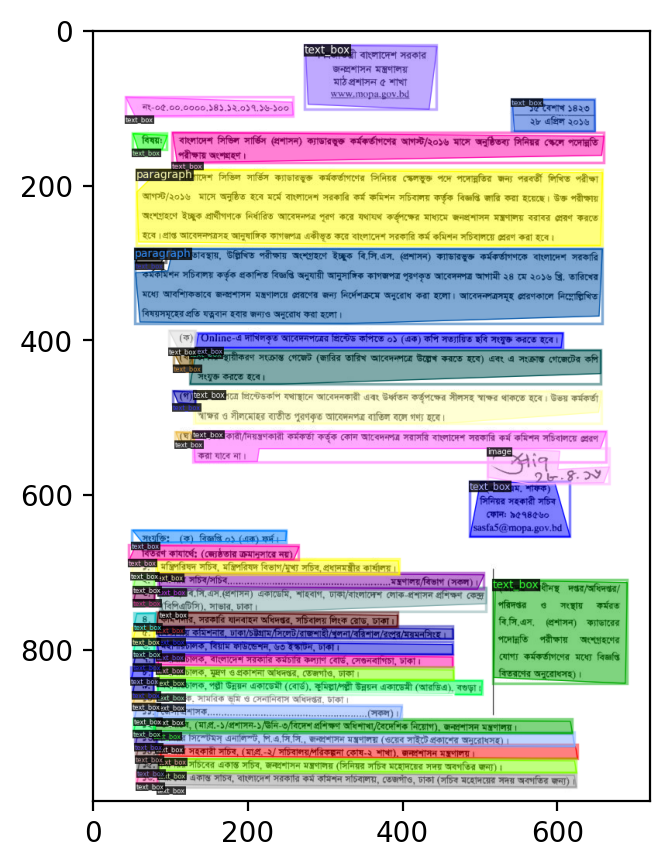

In [51]:
import os
from IPython.display import Image
example = dataset_dicts_train[0]
image = utils.read_image(example["file_name"], format="RGB")
print(example)
plt.figure(figsize=(5,5),dpi=200)
visualizer = Visualizer(image[:, :, ::-1], metadata=train_metadata_new, scale=1.0)
vis = visualizer.draw_dataset_dict(example)
plt.imshow(vis.get_image()[:, :,::-1])
plt.show()

In [52]:
import os
import cv2
import random
import numpy as np
import albumentations as A
from copy import deepcopy
from skimage.filters import gaussian

def image_copy_paste(img, paste_img, alpha, blend=True, sigma=1):
    if alpha is not None:
        if blend:
            alpha = gaussian(alpha, sigma=sigma, preserve_range=True)

        img_dtype = img.dtype
        alpha = alpha[..., None]
        img = paste_img * alpha + img * (1 - alpha)
        img = img.astype(img_dtype)

    return img

def mask_copy_paste(mask, paste_mask, alpha):
    raise NotImplementedError

def masks_copy_paste(masks, paste_masks, alpha):
    if alpha is not None:
        #eliminate pixels that will be pasted over
        masks = [
            np.logical_and(mask, np.logical_xor(mask, alpha)).astype(np.uint8) for mask in masks
        ]
        masks.extend(paste_masks)

    return masks

def extract_bboxes(masks):
    bboxes = []
    h, w = masks[0].shape
    for mask in masks:
        yindices = np.where(np.any(mask, axis=0))[0]
        xindices = np.where(np.any(mask, axis=1))[0]
        if yindices.shape[0]:
            y1, y2 = yindices[[0, -1]]
            x1, x2 = xindices[[0, -1]]
            y2 += 1
            x2 += 1
            y1 /= w
            y2 /= w
            x1 /= h
            x2 /= h
        else:
            y1, x1, y2, x2 = 0, 0, 0, 0

        bboxes.append((y1, x1, y2, x2))

    return bboxes

def bboxes_copy_paste(bboxes, paste_bboxes, masks, paste_masks, alpha, key):
    if key == 'paste_bboxes':
        return bboxes
    elif paste_bboxes is not None:
        masks = masks_copy_paste(masks, paste_masks=[], alpha=alpha)
        adjusted_bboxes = extract_bboxes(masks)

        #only keep the bounding boxes for objects listed in bboxes
        mask_indices = [box[-1] for box in bboxes]
        adjusted_bboxes = [adjusted_bboxes[idx] for idx in mask_indices]
        #append bbox tails (classes, etc.)
        adjusted_bboxes = [bbox + tail[4:] for bbox, tail in zip(adjusted_bboxes, bboxes)]

        #adjust paste_bboxes mask indices to avoid overlap
        if len(masks) > 0:
            max_mask_index = len(masks)
        else:
            max_mask_index = 0

        paste_mask_indices = [max_mask_index + ix for ix in range(len(paste_bboxes))]
        paste_bboxes = [pbox[:-1] + (pmi,) for pbox, pmi in zip(paste_bboxes, paste_mask_indices)]
        adjusted_paste_bboxes = extract_bboxes(paste_masks)
        adjusted_paste_bboxes = [apbox + tail[4:] for apbox, tail in zip(adjusted_paste_bboxes, paste_bboxes)]

        bboxes = adjusted_bboxes + adjusted_paste_bboxes

    return bboxes

def keypoints_copy_paste(keypoints, paste_keypoints, alpha):
    #remove occluded keypoints
    if alpha is not None:
        visible_keypoints = []
        for kp in keypoints:
            x, y = kp[:2]
            tail = kp[2:]
            if alpha[int(y), int(x)] == 0:
                visible_keypoints.append(kp)

        keypoints = visible_keypoints + paste_keypoints

    return keypoints

class CopyPaste(A.DualTransform):
    def __init__(
        self,
        blend=True,
        sigma=3,
        pct_objects_paste=0.1,
        max_paste_objects=None,
        p=0.5,
        always_apply=False
    ):
        super(CopyPaste, self).__init__(always_apply, p)
        self.blend = blend
        self.sigma = sigma
        self.pct_objects_paste = pct_objects_paste
        self.max_paste_objects = max_paste_objects
        self.p = p
        self.always_apply = always_apply

    @staticmethod
    def get_class_fullname():
        return 'copypaste.CopyPaste'

    @property
    def targets_as_params(self):
        return [
            "masks",
            "paste_image",
            #"paste_mask",
            "paste_masks",
            "paste_bboxes",
            #"paste_keypoints"
        ]

    def get_params_dependent_on_targets(self, params):
        image = params["paste_image"]
        masks = None
        if "paste_mask" in params:
            #handle a single segmentation mask with
            #multiple targets
            #nothing for now.
            raise NotImplementedError
        elif "paste_masks" in params:
            masks = params["paste_masks"]

        assert(masks is not None), "Masks cannot be None!"

        bboxes = params.get("paste_bboxes", None)
        keypoints = params.get("paste_keypoints", None)

        #number of objects: n_bboxes <= n_masks because of automatic removal
        n_objects = len(bboxes) if bboxes is not None else len(masks)

        #paste all objects if no restrictions
        n_select = n_objects
        if self.pct_objects_paste:
            n_select = int(n_select * self.pct_objects_paste)
        if self.max_paste_objects:
            n_select = min(n_select, self.max_paste_objects)

        #no objects condition
        if n_select == 0:
            return {
                "param_masks": params["masks"],
                "paste_img": None,
                "alpha": None,
                "paste_mask": None,
                "paste_masks": None,
                "paste_bboxes": None,
                "paste_keypoints": None,
                "objs_to_paste": []
            }

        #select objects
        objs_to_paste = np.random.choice(
            range(0, n_objects), size=n_select, replace=False
        )

        #take the bboxes
        if bboxes:
            bboxes = [bboxes[idx] for idx in objs_to_paste]
            #the last label in bboxes is the index of corresponding mask
            mask_indices = [bbox[-1] for bbox in bboxes]

        #create alpha by combining all the objects into
        #a single binary mask
        masks = [masks[idx] for idx in mask_indices]

        alpha = masks[0] > 0
        for mask in masks[1:]:
            alpha += mask > 0

        return {
            "param_masks": params["masks"],
            "paste_img": image,
            "alpha": alpha,
            "paste_mask": None,
            "paste_masks": masks,
            "paste_bboxes": bboxes,
            "paste_keypoints": keypoints
        }

    @property
    def ignore_kwargs(self):
        return [
            "paste_image",
            "paste_mask",
            "paste_masks"
        ]

    def apply_with_params(self, params, force_apply=False, **kwargs):  # skipcq: PYL-W0613
        if params is None:
            return kwargs
        params = self.update_params(params, **kwargs)
        res = {}
        for key, arg in kwargs.items():
            if arg is not None and key not in self.ignore_kwargs:
                target_function = self._get_target_function(key)
                target_dependencies = {k: kwargs[k] for k in self.target_dependence.get(key, [])}
                target_dependencies['key'] = key
                res[key] = target_function(arg, **dict(params, **target_dependencies))
            else:
                res[key] = None
        return res

    def apply(self, img, paste_img, alpha, **params):
        return image_copy_paste(
            img, paste_img, alpha, blend=self.blend, sigma=self.sigma
        )

    def apply_to_mask(self, mask, paste_mask, alpha, **params):
        return mask_copy_paste(mask, paste_mask, alpha)

    def apply_to_masks(self, masks, paste_masks, alpha, **params):
        return masks_copy_paste(masks, paste_masks, alpha)

    def apply_to_bboxes(self, bboxes, paste_bboxes, param_masks, paste_masks, alpha, key, **params):
        return bboxes_copy_paste(bboxes, paste_bboxes, param_masks, paste_masks, alpha, key)

    def apply_to_keypoints(self, keypoints, paste_keypoints, alpha, **params):
        raise NotImplementedError
        #return keypoints_copy_paste(keypoints, paste_keypoints, alpha)

    def get_transform_init_args_names(self):
        return (
            "blend",
            "sigma",
            "pct_objects_paste",
            "max_paste_objects"
        )

def copy_paste_class(dataset_class):
    def _split_transforms(self):
        split_index = None
        for ix, tf in enumerate(list(self.transforms.transforms)):
            if tf.get_class_fullname() == 'copypaste.CopyPaste':
                split_index = ix

        if split_index is not None:
            tfs = list(self.transforms.transforms)
            pre_copy = tfs[:split_index]
            copy_paste = tfs[split_index]
            post_copy = tfs[split_index+1:]

            #replicate the other augmentation parameters
            bbox_params = None
            keypoint_params = None
            paste_additional_targets = {}
            if 'bboxes' in self.transforms.processors:
                bbox_params = self.transforms.processors['bboxes'].params
                paste_additional_targets['paste_bboxes'] = 'bboxes'
                if self.transforms.processors['bboxes'].params.label_fields:
                    msg = "Copy-paste does not support bbox label_fields! "
                    msg += "Expected bbox format is (a, b, c, d, label_field)"
                    raise Exception(msg)
            if 'keypoints' in self.transforms.processors:
                keypoint_params = self.transforms.processors['keypoints'].params
                paste_additional_targets['paste_keypoints'] = 'keypoints'
                if keypoint_params.label_fields:
                    raise Exception('Copy-paste does not support keypoint label fields!')

            if self.transforms.additional_targets:
                raise Exception('Copy-paste does not support additional_targets!')

            #recreate transforms
            self.transforms = A.Compose(pre_copy, bbox_params, keypoint_params, additional_targets=None)
            self.post_transforms = A.Compose(post_copy, bbox_params, keypoint_params, additional_targets=None)
            self.copy_paste = A.Compose(
                [copy_paste], bbox_params, keypoint_params, additional_targets=paste_additional_targets
            )
        else:
            self.copy_paste = None
            self.post_transforms = None

    def __getitem__(self, idx):
        #split transforms if it hasn't been done already
        if not hasattr(self, 'post_transforms'):
            self._split_transforms()

        img_data = self.load_example(idx)
        if self.copy_paste is not None:
            paste_idx = random.randint(0, self.__len__() - 1)
            paste_img_data = self.load_example(paste_idx)
            for k in list(paste_img_data.keys()):
                paste_img_data['paste_' + k] = paste_img_data[k]
                del paste_img_data[k]

            img_data = self.copy_paste(**img_data, **paste_img_data)
            img_data = self.post_transforms(**img_data)
            img_data['paste_index'] = paste_idx

        return img_data

    setattr(dataset_class, '_split_transforms', _split_transforms)
    setattr(dataset_class, '__getitem__', __getitem__)

    return dataset_class

In [53]:
import os
import cv2
from torchvision.datasets import CocoDetection
# from copy_paste import copy_paste_class

min_keypoints_per_image = 10

def _count_visible_keypoints(anno):
    return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)

def _has_only_empty_bbox(anno):
    return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)

def has_valid_annotation(anno):
    # if it's empty, there is no annotation
    if len(anno) == 0:
        return False
    # if all boxes have close to zero area, there is no annotation
    if _has_only_empty_bbox(anno):
        return False
    # keypoints task have a slight different critera for considering
    # if an annotation is valid
    if "keypoints" not in anno[0]:
        return True
    # for keypoint detection tasks, only consider valid images those
    # containing at least min_keypoints_per_image
    if _count_visible_keypoints(anno) >= min_keypoints_per_image:
        return True

    return False

@copy_paste_class
class CocoDetectionCP(CocoDetection):
    def __init__(
        self,
        root,
        annFile,
        transforms
    ):
        super(CocoDetectionCP, self).__init__(
            root, annFile, None, None, transforms
        )

        # filter images without detection annotations
        ids = []
        for img_id in self.ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=None)
            anno = self.coco.loadAnns(ann_ids)
            if has_valid_annotation(anno):
                ids.append(img_id)
        self.ids = ids

    def load_example(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        target = self.coco.loadAnns(ann_ids)

        path = self.coco.loadImgs(img_id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, path))
        #print(os.path.join(self.root, path))
        #image = cv2.imread(os.path.join('', path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #convert all of the target segmentations to masks
        #bboxes are expected to be (y1, x1, y2, x2, category_id)
        masks = []
        bboxes = []
        for ix, obj in enumerate(target):
            masks.append(self.coco.annToMask(obj))
            
            b_box = obj['bbox']
            #b_box = [b_box[0],b_box[1],b_box[0]+b_box[2],b_box[1]+b_box[3]]
            #print(b_box)
            #bboxes.append(obj['bbox'] + [obj['category_id']] + [ix])
            bboxes.append(b_box + [obj['category_id']] + [ix])

        #pack outputs into a dict
        output = {
            'image': image,
            'masks': masks,
            'bboxes': bboxes
        }
        
        return self.transforms(**output)

In [54]:
"""
Copied and lightly modified from:
https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/visualize.py
"""

import os
import sys
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches, lines
from matplotlib.patches import Polygon

def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        x1, y1, width, height = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), width, height, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()

In [55]:
import albumentations as A
# aug_list = [A.Resize(800,800),#resize all images to fixed shape
#         CopyPaste(blend=True, sigma=1, pct_objects_paste=0.9, p=1.0) #pct_objects_paste is a guess
#     ]
        
    
#you can add any augmentation from albumentations to this list, for example, you can use:


aug_list = [A.Resize(800,800),\
            # A.ShiftScaleRotate(shift_limit=0.5, scale_limit=0.2, rotate_limit=45,
            #              interpolation=1, border_mode=4, value=None,
            #              always_apply=False, p=1.0),
            # A.augmentations.geometric.rotate.Rotate(limit=3,p=0.5),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.4),
            A.OneOf([A.Blur(), A.MotionBlur(), A.GaussNoise()], p=0.4),
            A.ZoomBlur (max_factor=1.31, step_factor=(0.01, 0.03), always_apply=False, p=0.3),
            # A.Blur(p=0.5),
            # A.CenterCrop(300,300,p=0.4),
            A.PixelDropout (dropout_prob=0.09, per_channel=False, drop_value=0, mask_drop_value=None, always_apply=False, p=0.4),
            CopyPaste(blend=True, sigma=13, pct_objects_paste=0.8, p=0.4) #pct_objects_paste is a guess
    ]


transform = A.Compose(
            aug_list, bbox_params=A.BboxParams(format="coco",min_visibility=0.10)
        )

In [56]:
data = CocoDetectionCP(
    'badlad/images/train', 
    'badlad/labels/coco_format/train/badlad-train-coco.json', 
    transform
)

loading annotations into memory...
Done (t=4.65s)
creating index...
index created!


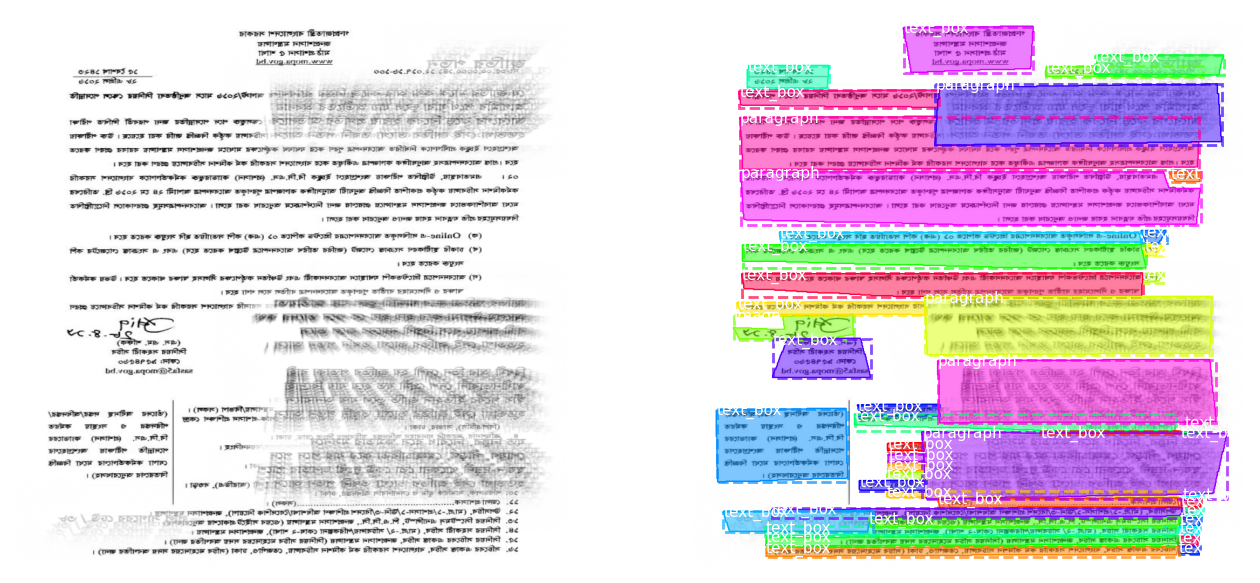

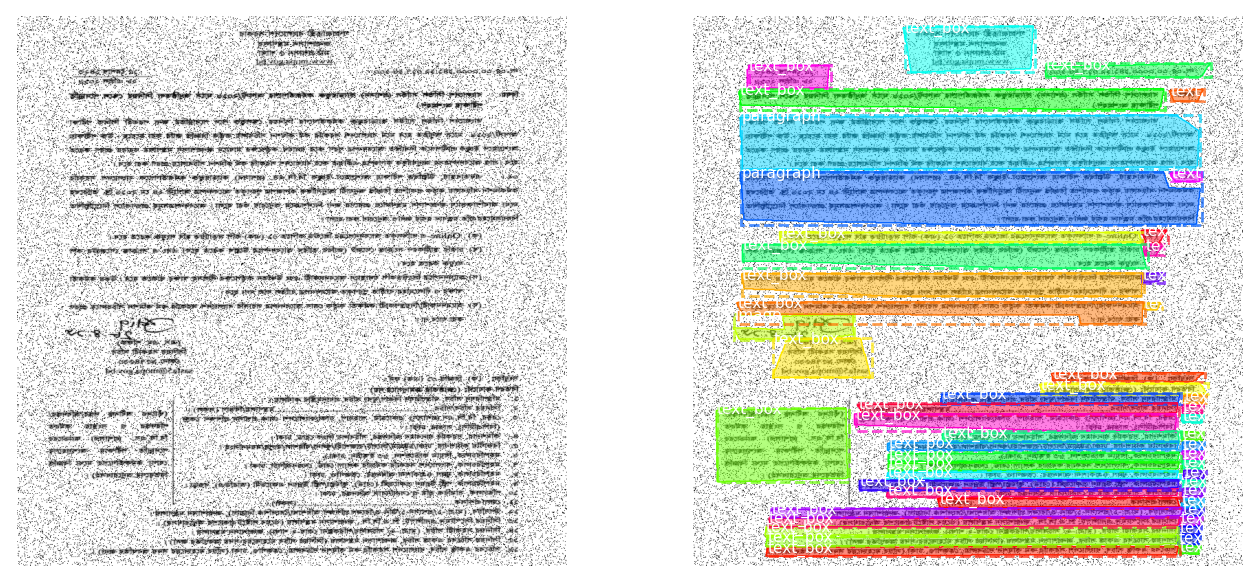

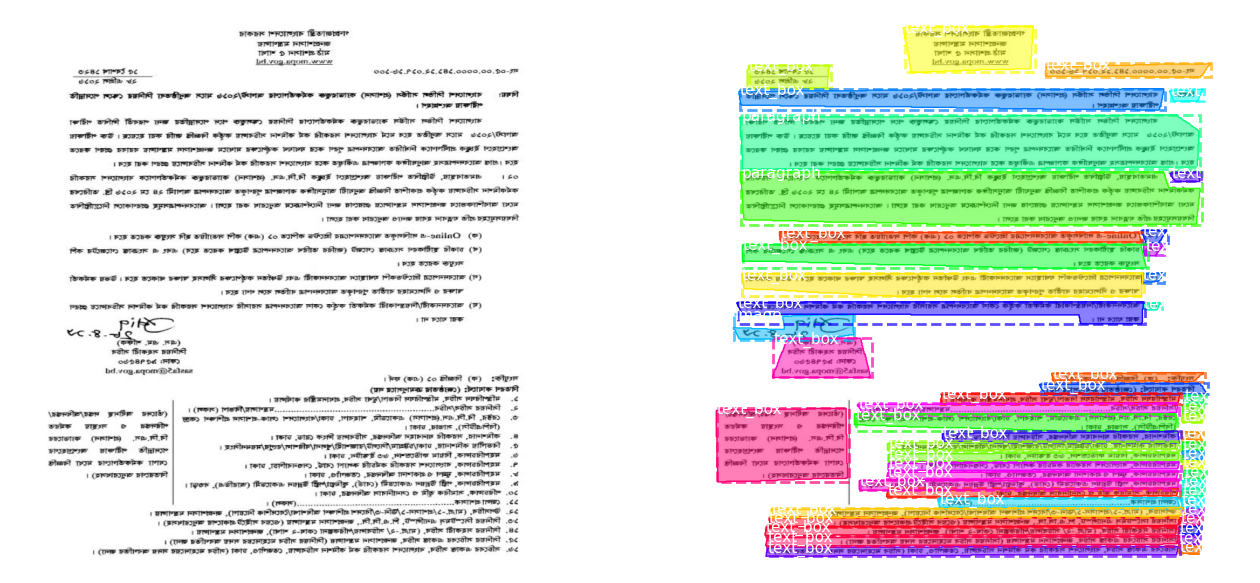

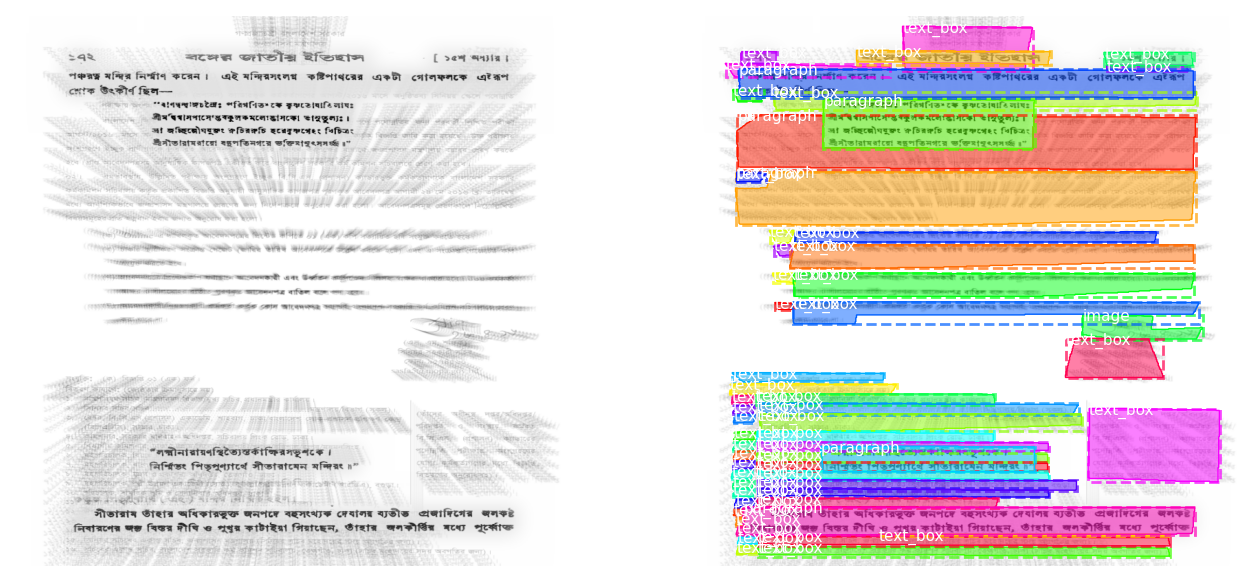

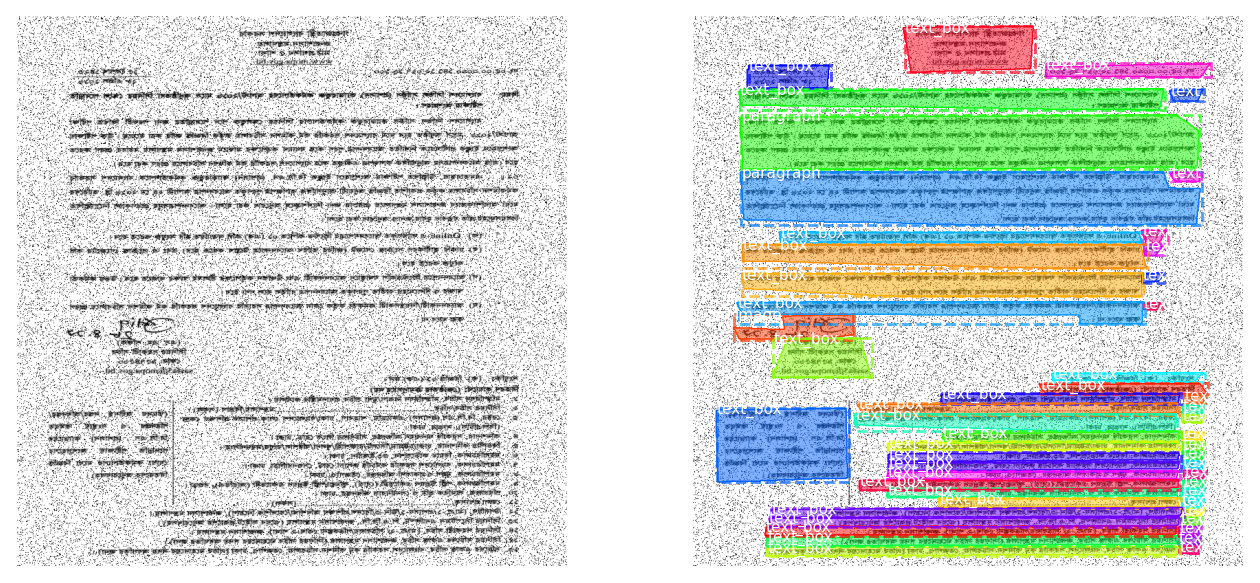

In [57]:
for i in range(5):

    img_data = data[0]

    f, ax = plt.subplots(1, 2, figsize=(16, 16))
    image = img_data['image']
    masks = img_data['masks']
    bboxes = img_data['bboxes']

    empty = np.array([])
    display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[0])

    if len(bboxes) > 0:
        boxes = np.stack([b[:4] for b in bboxes], axis=0)
        box_classes = np.array([b[-2] for b in bboxes])
        mask_indices = np.array([b[-1] for b in bboxes])
        show_masks = np.stack(masks, axis=-1)[..., mask_indices]
        class_names = {k: data.coco.cats[k]['name'] for k in data.coco.cats.keys()}
        display_instances(image, boxes, show_masks, box_classes, class_names, show_bbox=True, ax=ax[1])
    else:
        display_instances(image, empty, empty, empty, empty, show_mask=False, show_bbox=False, ax=ax[1])

In [58]:
data_id_to_num = {i:q for q,i in enumerate(data.ids)}

ALL_IDS = list(data_id_to_num.keys())

dataset_dicts_train = [i for i in dataset_dicts_train if i['image_id'] in ALL_IDS]

BOX_MODE = dataset_dicts_train[0]['annotations'][0]['bbox_mode']

# print(data_id_to_num)

In [59]:
import copy
import logging

import detectron2.data.transforms as T
import torch
from detectron2.data import detection_utils as utils

import json
import numpy as np
from pycocotools import mask
from skimage import measure

In [60]:
class MyMapper:
    """Mapper which uses `detectron2.data.transforms` augmentations"""

    def __init__(self, cfg, is_train: bool = True):

        self.is_train = is_train

        mode = "training" if is_train else "inference"
        #print(f"[MyDatasetMapper] Augmentations used in {mode}: {self.augmentations}")

    def __call__(self, dataset_dict):
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        img_id = dataset_dict['image_id']
        
        
        aug_sample = data[data_id_to_num[img_id]]
        
        image = aug_sample['image']
        
        image =  cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        
        
        bboxes = aug_sample['bboxes']
        box_classes = np.array([b[-2] for b in bboxes])
        boxes = np.stack([b[:4] for b in bboxes], axis=0)
        mask_indices = np.array([b[-1] for b in bboxes])
        
        
        masks = aug_sample['masks']
        
        annos =[]
        
        for enum,index in enumerate(mask_indices):
            curr_mask = masks[index]
            
            fortran_ground_truth_binary_mask = np.asfortranarray(curr_mask)
            encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
            ground_truth_area = mask.area(encoded_ground_truth)
            ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)
            contours = measure.find_contours(curr_mask, 0.5)
            
            annotation = {
        "segmentation": [],
        "iscrowd": 0,
        "bbox": ground_truth_bounding_box.tolist(), 
        "category_id": train_metadata_new.thing_dataset_id_to_contiguous_id[box_classes[enum]]  ,
        "bbox_mode":BOX_MODE
                
                
    }
            for contour in contours:
                contour = np.flip(contour, axis=1)
                segmentation = contour.ravel().tolist()
                annotation["segmentation"].append(segmentation)
                
            annos.append(annotation)
        

        image_shape = image.shape[:2]  # h, w

        
        instances = utils.annotations_to_instances(annos, image_shape)
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

In [61]:
import os

from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch

In [62]:
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg, sampler=None):
        return build_detection_train_loader(
            cfg, mapper=MyMapper(cfg, True), sampler=sampler
        )

In [63]:
print(train_metadata_new.thing_dataset_id_to_contiguous_id)

{0: 0, 1: 1, 2: 2, 3: 3}


In [64]:
from pathlib import Path
OUTPUT_DIR=Path("./output_aug2")
OUTPUT_MODEL=OUTPUT_DIR/"model_final.pth"

In [65]:
Pretrained_path=Path("output_aug1/model_final.pth")

In [66]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import HookBase
import detectron2.utils.comm as comm
from detectron2.engine import launch


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("LVISv1-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("my_dataset_train",)
# cfg.INPUT.MASK_FORMAT = "bitmask"

# cfg.DATASETS.VAL = ("my_dataset_val",)
# Pretrained_Path=Path("/kaggle/working/sam_vit_h_4b8939.pth")
                
# cfg.INPUT.MIN_SIZE_TEST= 400
# cfg.INPUT.MAX_SIZE_TEST = 400
cfg.INPUT.MIN_SIZE_TRAIN = 800
cfg.INPUT.MAX_SIZE_TRAIN = 800

# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0001

cfg.INPUT.FORMAT = 'BGR'
# cfg.DATASETS.TEST = (DATA_REGISTER_TEST,)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = str(Pretrained_path) # Let training initialize from model zoo
  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH =32 #increase it
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.GAMMA = 0.05
# The iteration number to decrease learning rate by GAMMA.

# cfg.SOLVER.WARMUP_FACTOR = 1.0 / 3
cfg.SOLVER.WARMUP_ITERS = 5
cfg.SOLVER.WARMUP_METHOD = "linear"



cfg.SOLVER.MAX_ITER =6000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
# cfg.MODEL.RETINANET.NUM_CLASSES = 273
# cfg.SOLVER.CHECKPOINT_PERIOD = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE=128




cfg.OUTPUT_DIR = str(OUTPUT_DIR)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = MyTrainer(cfg) 

trainer.resume_or_load(resume=True)
trainer.train()

print("#### TRAINING COMPLETE ####")
_ = trainer.model.train(True)  # turn off training
    
FileLink(str(OUTPUT_MODEL))

[07/07 15:05:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.22 GiB (GPU 0; 15.75 GiB total capacity; 12.13 GiB already allocated; 688.44 MiB free; 14.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF